In [1]:
import re
import pandas as pd
import numpy as np
import json
import subprocess
import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot')
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

Number of installed projects
Number of dropouts at each stage


In [ ]:
test_mode = 'BaseModel'
data_mode = 'Logs'
file = '/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Examples/' + test_mode + '/' + data_mode + '/world_log.log'

    
with open(file) as infile:
    for line in infile:
        print(line, end='')

In [ ]:
#find begin of an info string 


In [25]:
test_str = 'time: Mon 2017-02-06 11:26:51  INFO: EParamTypes::None : 805'
regex = re.compile('(INFO:\s)')
res = regex.findall(test_str)

In [26]:
print(res)

['INFO: ']


In [42]:
res = re.split(regex, test_str)
print(res)

['time: Mon 2017-02-06 11:26:51  ', 'INFO: ', 'EParamTypes::None : 805']


In [43]:
regex2 = re.compile('(::[\w]*\s*:\s*)')
res2 = regex2.findall(res[2])
print(res2)

['::None : ']


In [47]:
res2 = re.split(regex2, res[2])

In [53]:
regex3 = re.compile('[^:\s]+')
res3 = regex3.findall(res2[1])
print(res3)

['None']


In [66]:

test4_str = 'time: Mon 2017-02-06 19:15:14  INFO: N active agents at tick 5 : 453'
#check if it is 'N active agents at tick'
regex4 = re.compile('(N\s*active\s*agents\s*at\s*tick\s*)')
res4 = regex4.search(test4_str)
res4 = re.split(regex4, test4_str)
print(res4)

['time: Mon 2017-02-06 19:15:14  INFO: ', 'N active agents at tick ', '5 : 453']


In [68]:
regex5 = re.compile('(\s*:\s*)')
res5 = re.split(regex5, res4[2])
print(res5)

['5', ' : ', '453']


In [75]:
test6_str = 'time: Mon 2017-02-06 19:15:14  INFO: Number of installed projects: 0'
#check if it is 'Number of installed projects'
regex6 = re.compile('(Number\s*of\s*installed\s*projects\s*:\s*)')
res6 = regex6.search(test6_str)
print(res6)
res6 = re.split(regex6, test6_str)
print(res6)

<_sre.SRE_Match object; span=(37, 67), match='Number of installed projects: '>
['time: Mon 2017-02-06 19:15:14  INFO: ', 'Number of installed projects: ', '0']


In [9]:
def read_error_data_from_log(file, data_):
    regex_error_savings = re.compile('(INFO:\sNEGATIVE\sSAVINGS\s*)')
    regex_error_small_system = re.compile('(INFO:\sSMALL\sSYSTEM\s*)')
    N_SMALL_SAVINGS = 0
    N_SMALL_SYSTEMS = 0
    
    with open(file) as infile:
        for line in infile:
            if regex_error_savings.search(line):
                res = re.split(regex_error_savings, line)
                N_SMALL_SAVINGS = N_SMALL_SAVINGS + 1
            elif regex_error_small_system.search(line):
                res = re.split(regex_error_small_system, line)
                N_SMALL_SYSTEMS = N_SMALL_SYSTEMS + 1
            else:
                pass
            
    
    return (N_SMALL_SAVINGS, N_SMALL_SYSTEMS)
                
                
                

In [10]:
#Reads data from the given file into the given list
def read_data_from_log(file, data_):
    regex_begin_tick = re.compile('(N\s*active\s*agents\s*at\s*tick\s*)')
    regex_end_tick = re.compile('(Number\s*of\s*installed\s*projects\s*:\s*)')
    regex_data =  re.compile('(INFO:\s)')
    regex_data_check = re.compile('EParamTypes')
    regex_enum = re.compile('(::[\w]*\s*:\s*)')
    regex_enum_name = re.compile('([^:\s]+)')
    regex_1 = re.compile('(\s*:\s*)')
    
    
    with open(file) as infile:
        for line in infile:
            if regex_begin_tick.search(line):
                #parse tick number 
                #start new dictionary in the list
                data_.append({})

                #get tick 
                res = re.split(regex_1, re.split(regex_begin_tick, line)[-1])
                data_[-1]['N_AGENTS'] = float(res[-1])
                data_[-1]['tick'] = float(res[0])
            elif regex_end_tick.search(line):
                res = re.split(regex_end_tick, line)
                data_[-1]['N_PROJECTS'] = float(res[-1])
            else:
                if (regex_data.search(line)) and (regex_data_check.search(line)):
                    res = re.split(regex_data, line)
                    #get last part and enum name 
                    #last part is number
                    res2 = re.split(regex_enum, res[-1])
                    #get enum name 
                    data_[-1]['EParamTypes::' + re.split(regex_enum_name, res2[-2])[-2]] = float(res2[-1])
#    print(data_)
            

In [11]:
def get_subset_data(data_):
    #data_column_names
    data_columns = {'EParamTypes::HOStateDroppedOutNCDecStage':[],\
                   'EParamTypes::HOStateDroppedOutSEIStage':[],\
                   'EParamTypes::HOStateDroppedOutDesignStage':[]}
    tick = []
    i = 0
    #collect data for each tick 
    for row in data_:
        for key, value in data_columns.items():
            value.append(0.0)
            if key in row:
                value[-1] = row[key]
        tick.append(i)
        i = i + 1
    
    return data_columns

#print(data_columns)

In [99]:
test_mode = 'BaseModel'
data_mode = 'Logs'
version = '_vlow'
#file = '/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Examples/' + test_mode + '/' + data_mode + '/world_log' + \
#        version + '.log'
    
    
#get latest file 
files = glob.glob('..\\..\\ABMIRISLab\\Examples\\' + test_mode + '\\' + data_mode +\
                 '\\*[_log].log')
files.sort(key=os.path.getmtime, reverse=True)
file = files[1]    

#if find N active agents at tick
# start data for the tick 
#parse data - name of the enum, value
data_v1 = []
read_data_from_log(file, data_v1)
data_subset_v1 = get_subset_data(data_v1)

In [100]:
adjustments = read_error_data_from_log(file, [])

print(adjustments)

(104, 0)


In [101]:
test_mode = 'BaseModel'
data_mode = 'Logs'
version = '_vhigh'
#file = '/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Examples/' + test_mode + '/' + data_mode + '/world_log' + \
#        version + '.log'
    
    
#get latest file 
files = glob.glob('..\\..\\ABMIRISLab\\Examples\\' + test_mode + '\\' + data_mode +\
                 '\\*[_log].log')
files.sort(key=os.path.getmtime, reverse=True)
file = files[0]    

#if find N active agents at tick
# start data for the tick 
#parse data - name of the enum, value
data_v2 = []
read_data_from_log(file, data_v2)
data_subset_v2 = get_subset_data(data_v2)

In [102]:
df_v1 = pd.DataFrame(
data_subset_v1
)
df_v1.index.name = 'tick'

In [103]:
df_v2 = pd.DataFrame(
data_subset_v2
)
df_v2.index.name = 'tick'

[array([[  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  4.],
       [  3.],
       [  4.],
       [  3.],
       [  5.],
       [  6.],
       [  7.],
       [  9.],
       [ 10.],
       [ 10.],
       [ 10.],
       [ 10.],
       [ 11.],
       [ 10.],
       [ 13.],
       [  9.],
       [  8.],
       [  6.],
       [  7.],
       [  5.],
       [  5.],
       [  5.],
       [  6.],
       [  5.],
       [  5.],
       [  5.],
       [  6.],
       [  6.],
       [  7.],
       [  6.],
       [  5.],
       [  5.],
       [  5.],
       [  5.],
       [  7.],
       [  6.],
       [  6.],
       [  5.],
       [  5.],
       [  4.],
       [  7.],
       [  6.],
       [  8.],
       [  7.],
       [  7.],
       [  6.],
       [  6.],
       [  4.],
       [  5.],
       [  5.],
       [  9.],
       [  7.],
       [  8.],
       [  6.],
       [ 

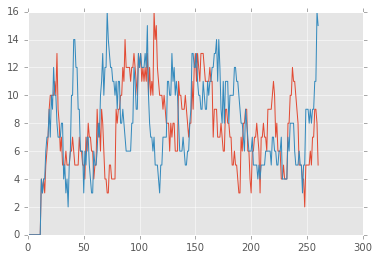

In [80]:
columns = ['EParamTypes::HOStateDroppedOutNCDecStage']
data_ = [df_v1[columns].values, df_v2[columns].values]
index_ = df_v1[columns].index.values
print(data_)
plt.plot(df_v1[columns].index.values, df_v1[columns].values, df_v1[columns].index.values, df_v2[columns].values)


In [ ]:
df_v1[columns].index.values

In [54]:
df_v1[columns].values.shape

(261, 1)

In [ ]:
df_v1.head(10)

In [104]:
test_mode = 'BaseModel'
data_mode = 'Test1'

#names of columns in a file
names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
for i in range(3):
    names.append('sei_markup_' + str(i))



#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\'+ test_mode + '\\' + data_mode + \
                 '\\*[_w].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top 1 files 
for file in files[0:2]:
    df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
    dfs_.append(df_)

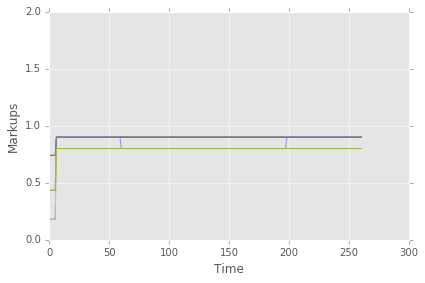

In [105]:
data_mode = 'bm_'
test_mode = 'markups'

fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)
#if ncols = 1  - transform into list
axes = [axes_]

axes[0].plot(dfs_[0][['sei_markup_' + str(i) for i in range(3)]])
axes[0].plot(dfs_[1][['sei_markup_' + str(i) for i in range(3)]])


axes[0].set_xlabel("Time")
axes[0].set_ylabel("Markups")

axes[0].set_ylim([0.0,2.0])

plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode +  '.png', dpi=300)
plt.show()    

In [ ]:
dfs_[0].head(10)

In [79]:
#x - tick 
#y - drop outs per tick 

In [19]:
N_TICKS_DISPLAY = 260

In [20]:
N_TICKS = 260

In [84]:
columns = ['EParamTypes::HOStateDroppedOutNCDecStage', \
            'EParamTypes::HOStateDroppedOutSEIStage',\
            'EParamTypes::HOStateDroppedOutDesignStage']

In [85]:
data_mode = 'bm_'
test_mode = 'drops'


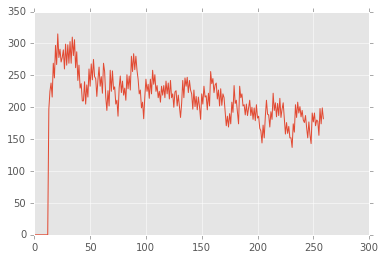

In [84]:
plt.plot(df_v1[columns[-2]][0:N_TICKS_DISPLAY])

In [86]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap_custom = cm.get_cmap('YlGn')
incomes = norm(range(len(columns)))
colors_ = []

i = 0
for column in columns:
    colors_.append(cmap_custom(i))
    i = i + 1
    
print(colors_)

[(1.0, 1.0, 0.89803922176361084, 1.0), (0.9990157632266774, 0.99963091121000403, 0.89262591951033643, 1.0), (0.9980315264533548, 0.99926182242000805, 0.88721261725706213, 1.0)]


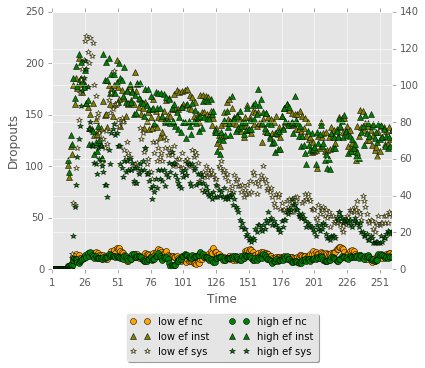

In [106]:
data_mode = 'bm_unc_'
test_mode = 'drops'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
axes = [axes_]

axes_0_tw = axes[0].twinx()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = df_v1.index.values[0:N_TICKS_DISPLAY] + 1

lines = []
i = 0


markers = ["ro", "r^", "r*"]
markerfacecolors = colors_
colors = ['r', 'r', 'r']
labels_raw = ["nc", "inst", "sys"]
labels = ['low ef ' + x for x in labels_raw]

for column in columns[0:2]:
    pi, = axes[0].plot(ind, df_v1[column][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
    pi.set_markerfacecolor(markerfacecolors[i])
    lines.append(pi)
    i = i + 1
    
#plot on a separate axis
pi, = axes_0_tw.plot(ind, df_v1[columns[-1]][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
pi.set_markerfacecolor(markerfacecolors[i])
lines.append(pi)
i = i + 1

    
markers = ["go", "g^", "g*"]
colors = ['g', 'g', 'g']
labels = ['high ef ' + x for x in labels_raw]

i = 0
for column in columns[0:2]:
    pi, = axes[0].plot(ind, df_v2[column][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
    lines.append(pi)
    i = i + 1
    
#plot on a separate axis
pi, = axes_0_tw.plot(ind, df_v2[columns[-1]][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
lines.append(pi)
i = i + 1
    

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Dropouts")


#axes[0].set_autoscaley_on(False)
axes[0].set_xlim([1,N_TICKS_DISPLAY])
#axes_0_tw.set_ylim([0.0, 5.0])
start = 1
end = N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))




# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)




plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode +  '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


In [114]:
#number of dropouts as stacked bars

In [115]:
#number of installations per tick

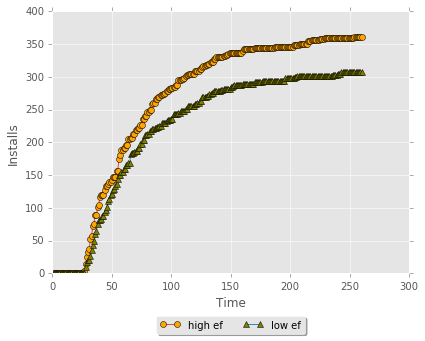

In [107]:
data_mode = 'bm_unc_'
test_mode = 'inst'
column = ['N_installed_sum']
colors_ = ['orange', 'olive', 'khaki'] 
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
axes = [axes_]

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = dfs_[0].index.values[0:N_TICKS_DISPLAY] + 1

lines = []

markers = ["o-", "^-", "*-"]
markerfacecolors = colors_
colors = ['r', 'r', 'r']
labels = ['high ef', 'low ef']

for i in range(2) :
    pi, = axes[0].plot(ind, dfs_[i][column][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
    pi.set_markerfacecolor(markerfacecolors[i])
    lines.append(pi)
    

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Installs")
    
# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='lower center', bbox_to_anchor=(0.5, -0.25),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)




plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode +  '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


NameError: name 'df' is not defined

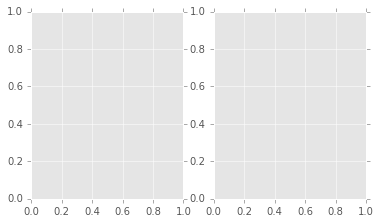

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(bottom=0.25)




ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = df.index.values[0:N_TICKS_DISPLAY] + 1

lines = []
i = 0


markers = ["ro", "r^", "r*"]
colors = ['r', 'r', 'r']
labels = ["er", "el", "el"]

for column in columns:
    pi, = axes[0].plot(ind, df_v1[column][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
    lines.append(pi)
    i = i + 1
    


#p1, = axes[0].plot(ind, df['sem_max'][0:N_TICKS_DISPLAY], "g-", label="max")    
p2, = axes[0].plot(ind, df['sei_0'][0:N_TICKS_DISPLAY], "ro", label="er")
p3, = axes[0].plot(ind, df['sei_1'][0:N_TICKS_DISPLAY], "r^", label="el")
p4, = axes[0].plot(ind, df['sei_2'][0:N_TICKS_DISPLAY], "r*", label="el")


#axes[0].fill_between(ind, 
#                  df['sem_max'][0:N_TICKS_DISPLAY]-2*df_std['sem_max'][0:N_TICKS_DISPLAY], 
#                  df['sem_max'][0:N_TICKS_DISPLAY]+2*df_std['sem_max'][0:N_TICKS_DISPLAY], 
#                  color='g', 
#                  alpha=0.2)

#axes[0].fill_between(ind, 
#                  df['sei_0'][0:N_TICKS_DISPLAY]-2*df_std['sei_0'][0:N_TICKS_DISPLAY], 
#                  df['sei_0'][0:N_TICKS_DISPLAY]+2*df_std['sei_0'][0:N_TICKS_DISPLAY], 
#                  color='r', 
#                  alpha=0.2)

#axes[0].fill_between(ind, 
#                  df['sei_1'][0:N_TICKS_DISPLAY]-2*df_std['sei_1'][0:N_TICKS_DISPLAY], 
#                  df['sei_1'][0:N_TICKS_DISPLAY]+2*df_std['sei_1'][0:N_TICKS_DISPLAY], 
#                  color='r', 
#                  alpha=0.2)

#axes[0].fill_between(ind, 
#                  df['sei_2'][0:N_TICKS_DISPLAY]-2*df_std['sei_2'][0:N_TICKS_DISPLAY], 
#                  df['sei_2'][0:N_TICKS_DISPLAY]+2*df_std['sei_2'][0:N_TICKS_DISPLAY], 
#                  color='r', 
#                  alpha=0.2)


#lines = [p1, p2, p3, p4]
lines = [p2, p3, p4]
axes[0].legend(lines, [l.get_label() for l in lines], fontsize='10', loc=2)

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Efficiency")
#axes[0].set_title('Efficiency relative to the \n maximum available', fontsize=10)
axes[0].set_title('Efficiency', fontsize=10)

axes[0].set_autoscaley_on(False)
axes[0].set_xlim([1,15])
axes[0].set_ylim([0.15, 0.40])
start = 1
end = 16
axes[0].xaxis.set_ticks(np.arange(start, end, 2))


#agents_to_show = ['sem_rel_min'] + ['sei_rel_' + str(i) for i in range(3)]
#markers = ["g-", "ro", "r^", "r*"]
#colors = ['g', 'r', 'r', 'r']
#labels = ["min", "er", "el", "el"]


agents_to_show = ['sei_rel_' + str(i) for i in range(3)]
markers = ["ro", "r^", "r*"]
colors = ['r', 'r', 'r']
labels = ["er", "el", "el"]

i = 0
lines = []

for agent in agents_to_show:
    pi, = axes[1].plot(ind, df[agent][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
    lines.append(pi)
    i = i + 1

#i = 0
#for agent in agents_to_show:
#    axes[1].fill_between(ind, 
#                  df[agent][0:N_TICKS_DISPLAY]-2*df_std[agent][0:N_TICKS_DISPLAY], 
#                  df[agent][0:N_TICKS_DISPLAY]+2*df_std[agent][0:N_TICKS_DISPLAY], 
#                  color=colors[i], 
#                  alpha=0.2)
#    i = i + 1
    

#axes[1].legend(lines, [l.get_label() for l in lines], fontsize='10', loc=2)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Reliability")
#axes[1].set_title('Reliability relative to the \n minimum available', fontsize=10)
axes[1].set_title('Reliability', fontsize=10)
    
axes[1].set_autoscaley_on(False)
axes[1].set_xlim([1,15])
axes[1].set_ylim([0, 45])
axes[1].xaxis.set_ticks(np.arange(start, end, 2))
    
    
plt.tight_layout()
plt.savefig('Simulation_results_relatives_' + data_mode + '.png', dpi=300)
plt.show()

In [ ]:
df = pd.DataFrame(
{
        'HOStateDroppedOutNCDecStage':data_column1,
        'HOStateDroppedOutSEIStage':data_column2
    }
)
df.index.name = 'tick'
df

In [ ]:
df = pd.DataFrame(
data_columns
)
df.index.name = 'tick'
df

In [ ]:
#TODO plot drop out rates per type, plot number of installations per efficiency assumption

In [ ]:
#shares amoung installers per type? - number of installations per installer

In [ ]:
#different efficiencies - number of installations - efficiency at the same price

In [ ]:
#read old file


In [ ]:
dir(df.index)

In [2]:
test_mode = 'BaseModel'
data_mode = 'Test1'
mode = 'NEW'
model_file = '..\\..\\ABMIRISLab\\Examples\\' + test_mode + '\\basemodel.model'
save_path = '..\\..\\ABMIRISLab\\Saves\\' + test_mode + '\\' + data_mode + '\\basemodel.model'

w_file = '..\\..\\ABMIRISLab\\Examples\\' + test_mode + '\\w.json'
sem_file = '..\\..\\ABMIRISLab\\Examples\\' + test_mode + '\\sem.json'
ho_file = '..\\..\\ABMIRISLab\\Examples\\' + test_mode + '\\ho.json'

In [96]:
adjustment = 1.25
el_price = 0.15

In [97]:
#update path to save file 
#open file at path 
#rewrite it 
#'path_so_save=' + save_path
#'mode=NEW'

with open(model_file, 'w') as model_file_:
    model_file_.write('path_to_save={}\n'.format(save_path))
    model_file_.write('mode={}\n'.format('NEW'))

with open(w_file) as infile:
    w_setup = json.load(infile)
    for setting in w_setup['WorldSettings']['params_exog']:
        if 'EParamTypes::ScenarioEfficiencyAdjustment' in setting:
            setting['EParamTypes::ScenarioEfficiencyAdjustment'] = adjustment
        if 'EParamTypes::ElectricityPriceUCDemand' in setting:
            setting['EParamTypes::ElectricityPriceUCDemand'] = el_price
        if 'EParamTypes::ElectricityPriceUCSupply' in setting:
            setting['EParamTypes::ElectricityPriceUCSupply'] = el_price
            
    with open(w_file, 'w') as outfile:
        json.dump(w_setup, outfile)
            
with open(sem_file) as infile:
    sem_setup = json.load(infile)
    if (adjustment > 1.0):
        sem_setup['costs_base'] = 0.39 * (1 + (adjustment - 1) / 2)
        sem_setup['costs_base'] = 0.39
    else:
        sem_setup['costs_base'] = 0.39
            
    for setting in sem_setup['params']:
        if 'EParamTypes::SEMEfficiencyUpgradeResearch' in setting:
            setting['EParamTypes::SEMEfficiencyUpgradeResearch'] = 0.0
    
    with open(sem_file, 'w') as outfile:
        json.dump(sem_setup, outfile)
        
        
with open(ho_file) as infile:
    ho_setup = json.load(infile)
    ho_setup['House']['roof_effective_size'] = 'FORMULA::0.25'
    
    with open(ho_file, 'w') as outfile:
        json.dump(ho_setup, outfile)
    


In [98]:
path = 'BaseModel.exe'
args = [path, mode, model_file]
subprocess.call([path, mode, model_file])

0

http://stackoverflow.com/questions/10101700/moving-matplotlib-legend-outside-of-the-axis-makes-it-cutoff-by-the-figure-box
    http://stackoverflow.com/questions/8971834/matplotlib-savefig-with-a-legend-outside-the-plot
    http://stackoverflow.com/questions/10101700/moving-matplotlib-legend-outside-of-the-axis-makes-it-cutoff-by-the-figure-box?noredirect=1&lq=1

In [ ]:
#assume 8 per watt 
#small roof - only for 5 kw
#bill 5*5*2

In [90]:
#el bill
el_bill = 5*5*2*30*0.15
print(el_bill)

225.0


In [91]:
#savings
#system price 
system_price = 8*5*1000

In [92]:
#interest rate 5%
interest_rate = 0.05
total_payments = system_price + system_price*interest_rate*25/2

In [93]:
savings = (0.15*25*5*5*365 - total_payments)/(el_bill*12*25)

In [94]:
print(savings)

-0.45601851851851855


In [95]:
print(total_payments)

65000.0


In [96]:
income = 0.15*25*5*5*365

In [97]:
print(income)

34218.75


In [98]:
savings = ((el_bill*12*25 - (el_bill*12*25 - 0.15*25*5*5*365)) - total_payments)/(el_bill*12*25)

In [99]:
print(savings)

-0.45601851851851855


In [3]:
#create fake data - matrix 10*10 with random number of installations 

fake_data = np.random.rand(10,10)

fake_data = fake_data * 100
        




In [4]:
print(fake_data)

[[ 73.00464472  66.36029531  92.31578591  48.45415688   2.12335901
   80.48322658  58.64117045  44.57834072  70.01176613  84.46462118]
 [  8.01371505  20.58032204  42.34754018  21.93961205  94.6360953
   44.67449745  26.55711896  41.50899949  44.73496607  40.85806731]
 [ 64.15765933  57.18382623  56.33978229  37.73896397  17.40427217
   27.22763068  42.93850311  50.39171393  59.49806417  43.7066184 ]
 [ 86.73796907  39.81839152  76.92963845  95.01576941  58.7988436
   75.51126937  42.69690508  28.21851133  15.52278728  41.3376596 ]
 [ 91.49002919  81.28124529  26.61714341  77.58397399  45.50644703
   24.7685508   98.21360604   0.81212472  55.74781144  95.86018622]
 [ 21.56206894  39.32591421  85.17501601  76.43221026  87.6580207
   60.59735117  92.55498752  20.49874692  39.97783431  74.96292256]
 [ 12.33419492  87.98540041  48.04517758  47.60092111  21.10069743
    8.39240932  82.49897299  66.99358848  32.07833191  28.99020718]
 [ 59.89514107  95.88071302  58.6728239    5.66412531  67.

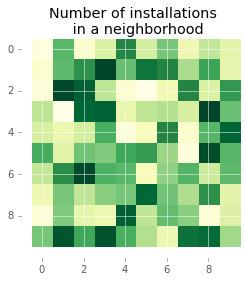

In [8]:
fig, ax = plt.subplots()

cmap_custom = cm.get_cmap('YlGn')

image = np.random.uniform(size=(10, 10))
ax.imshow(image, cmap=cmap_custom, interpolation='nearest')
ax.set_title('Number of installations \n in a neighborhood')

# Move left and bottom spines outward by 10 points
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.tight_layout()
data_mode = 'test'
plt.savefig('Simulation_results_spatial_' + data_mode + '.png', dpi=300)

plt.show()



In [9]:
def create_fake_data():
    #data_column_names
    data_columns = {'Efficiency_of_panel':[],\
                   'Count':[],\
                   'Price_per_watt':[]}
    
    data_columns['Efficiency_of_panel'] = np.random.uniform(size=(100)) * 0.18
    data_columns['Count'] = np.random.uniform(size=(100)) * 100
    data_columns['Price_per_watt'] = np.random.uniform(size=(100)) * 4
    
    
    
    return data_columns


In [11]:
#fake data
data_columns = create_fake_data()
df_agg_top = pd.DataFrame(
data_columns
)
df_agg_top.index.name = 'installer'


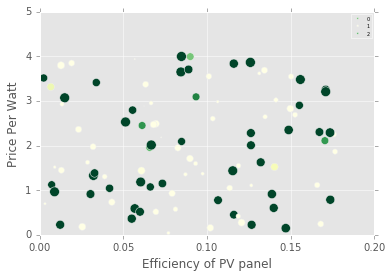

In [18]:
N = 100





x = df_agg_top['Efficiency_of_panel']
y = df_agg_top['Price_per_watt']
norm = matplotlib.colors.Normalize(vmin=df_agg_top['Count'][N-1], vmax=df_agg_top['Count'][0])
cmap_custom = cm.get_cmap('YlGn')
area = norm(df_agg_top['Count'])
color = []

for area_x in area:
    color.append(cmap_custom(area_x/2))
    
#color[1] = (0.0, 0.65, 0.75, 1.0)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Efficiency of PV panel')
ax.set_ylabel('Price Per Watt')

ax.set_autoscaley_on(False)
ax.set_xlim([0,0.2])
ax.set_ylim([0,5])
    
#plt.xlabel('Price Per Watt')
#plt.ylabel('System Size AC')
#plt.title('Number of Installations Per Company')

ax.scatter(x, y, s=df_agg_top['Count'],  c = color )
handles, labels = ax.get_legend_handles_labels()


#names are here
#df_agg.index.values[0:3]

#colors are here
#color[0:3]

artists = []
labels = []

#create custom artists
for i in range(3):
    artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[i]))
    labels.append(df_agg_top.index.values[i])


class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Circle(xy=center, radius=width/10)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    

#Create legend from custom artist/label lists
ax.legend(artists,
          labels,
         handler_map={mpatches.Circle: HandlerEllipse()}, bbox_to_anchor=(0.9, 0.9),
           bbox_transform=plt.gcf().transFigure, fontsize=5
         )



#plt.scatter(x, y, s=df_agg_top['Count'],  c = color )
data_mode = 'test'
plt.savefig('Simulation_results_installers_' + data_mode + '.png', dpi=300)
plt.show()